In [1]:
!pip install ../input/riiid-answer-correctness-prediction-utilities/site-packages/datatable-0.11.0-cp37-cp37m-manylinux2010_x86_64.whl

Processing /kaggle/input/riiid-answer-correctness-prediction-utilities/site-packages/datatable-0.11.0-cp37-cp37m-manylinux2010_x86_64.whl
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
from datetime import datetime

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import datatable as dt

from scipy.stats import skew, kurtosis

import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000
import matplotlib.pyplot as plt
import seaborn as sns

from numba import jit
from sklearn.metrics import roc_auc_score

## 1. Introduction

This competition's objective is predicting whether the students are able to answer their next questions correctly or not. Dataset consist student's historic performance, the performance of other students on the same question, metadata about the question itself, and more. There are more than **100 million** rows in training set so it is not possible to read `train.csv` into memory without downcasting data types of the columns. It is better to use `numpy.ndarray` instead of `pandas.DataFrame` since memory consumption is 3 times larger in dataframes, but dataframes will be used in this notebook because they are very convenient.

### 1.1 Training Set

`train.csv` is read into memory with `datatable.fread` for two reasons. First, `pandas.read_csv` takes more than 10 times to load the data compared to `datatable.fread`, and second, `pandas.read_csv` leaks memory. For large datasets like this, memory leak is not negligible. After `train.csv` is read with `datatable.fread`, it is converted to `pandas DataFrame`.

* `row_id`: Unique ID of the row
* `timestamp`: Time between users current interaction and the first event completion from that user
* `user_id`: Unique ID of the user
* `content_id`: Unique ID of the user interaction (question or lecture)
* `content_type_id`: Type of the content (question = 0 and lecture = 1)
* `task_container_id`: Unique ID of the batch of questions or lectures (monotonically increasing for each user)
* `user_answer`: Users answer to the question (-1, 0, 1, 2, 3 ) 
* `answered_correctly`: User answered the question correctly or not (-1, 0, 1)
* `prior_question_elapsed_time`: Average time a user spent to answer each question on previous question bundle (ignoring any lectures in between)
* `prior_question_had_explanation`: Whether or not the user saw an explanation after answering the previous question bundle (ignoring any lectures in between)

There are **101,230,332** rows and **10** columns in training set. All of the columns had to be downcasted for using memory efficiently. `prior_question_had_explanation` is a binary feature, but it has missing values. Even though it has only 0 and 1 integer values, pandas forces an array of integers with any missing values to become floats. Using float type for a binary feature can be avoided by filling the missing values and casting it to an integer type. After that final touch, training set memory consumption is reduced to 2.7 GB.

In [3]:
TRAIN_DTYPES = {
    'row_id': np.uint32,
    'timestamp': np.uint64,
    'user_id': np.uint32,
    'content_id': np.uint16,
    'content_type_id': np.uint8,
    'task_container_id': np.uint16,
    'user_answer': np.int8,
    'answered_correctly': np.int8,
    'prior_question_elapsed_time': np.float32,
    'prior_question_had_explanation': 'boolean'
}

df_train = dt.fread('../input/riiid-test-answer-prediction/train.csv').to_pandas()

for column, dtype in TRAIN_DTYPES.items():
    df_train[column] = df_train[column].astype(dtype) 
    
df_train['prior_question_had_explanation'] = df_train['prior_question_had_explanation'].astype(np.float16).fillna(-1).astype(np.int8)

print(f'Training Set Shape = {df_train.shape}')
print(f'Training Set Memory Usage = {df_train.memory_usage().sum() >> 20:.2f} MB')

Training Set Shape = (101230332, 10)
Training Set Memory Usage = 2703.00 MB


### 1.2 Questions

`questions.csv` is the metadata of the questions that are asked to users. Unique identifier of the questions is `content_id` in training set, but it should be joined to questions (`content_type_id == 0`). Even though, questions metadata consume very few memory, it should be downcasted, because it will be joined to training set.

* `question_id`: Unique ID of the question (0 - 13522)
* `bundle_id`: Unique ID of the bundle (0 - 13522)
* `correct_answer`: Correct answer of the question (0, 1, 2, 3)
* `part`: Category code of the question (1, 2, 3, 4, 5, 6, 7)
* `tags`: One or more detailed tag codes for the question

There are **13523** unique questions and **9765** unique bundles. Questions are multiple choice with 4 choices and they are asked in 7 different parts in tests.

In [4]:
QUESTIONS_DTYPES = {
    'question_id': np.uint16,
    'bundle_id': np.uint16,
    'correct_answer': np.uint8,
    'part': np.uint8,
}

df_questions = pd.read_csv('../input/riiid-test-answer-prediction/questions.csv', dtype=QUESTIONS_DTYPES)

print(f'Questions Shape = {df_questions.shape} - Unique Questions = {df_questions["question_id"].nunique()} - Unique Bundles = {df_questions["bundle_id"].nunique()}')
print(f'Questions Memory Usage = {df_questions.memory_usage().sum() >> 20:.2f} MB')

Questions Shape = (13523, 5) - Unique Questions = 13523 - Unique Bundles = 9765
Questions Memory Usage = 0.00 MB


### 1.3 Lectures

`lectures.csv` is the metadata of the lectures watched by users as they progress in their education. Unique identifier of the lectures is `content_id` in training set, but it should be joined to lectures (`content_type_id == 1`). Even though, lectures metadata consume very few memory, it should be downcasted, because it will be joined to training set.

* `lecture_id`: Unique ID of the question (89 - 32736)
* `part`: Category code of the lecture (1, 2, 3, 4, 5, 6, 7)
* `tag`: A single tag code of the lecture
* `type_of`: Brief description of the core purpose of the lecture (concept, solving question, intention, starter)

There are **418** unique lectures and those lectures can be grouped into 4 major categories based on their types, and they are prepared for 7 parts of the tests.

In [5]:
LECTURES_DTYPES = {
    'lecture_id': np.uint16,
    'tag': np.uint16,
    'part': np.uint8
}

df_lectures = pd.read_csv('../input/riiid-test-answer-prediction/lectures.csv', dtype=LECTURES_DTYPES)
df_lectures['type_of'] = np.uint8(df_lectures['type_of'].map({'concept': 0, 'solving question': 1, 'intention': 2, 'starter': 3}))

print(f'Lectures Shape = {df_lectures.shape} - Unique Lectures = {df_lectures["lecture_id"].nunique()}')
print(f'Lectures Memory Usage = {df_lectures.memory_usage().sum() >> 20:.2f} MB')

Lectures Shape = (418, 4) - Unique Lectures = 418
Lectures Memory Usage = 0.00 MB


### 1.4 Test Set and Submissions

This is a time-series code competition, so real test set data is recieved and predictions are made with Kaggle's time-series API. `example_test.csv` is a placeholder and the real test set is hidden. The purpose of a placeholder test set is, showing the structure of real test set and testing whether the submissions are in correct format or not. There will be roughly 2.5 million questions in the real test set.

In [6]:
df_example_test = pd.read_csv('../input/riiid-test-answer-prediction/example_test.csv')

print(f'Example Test Set Shape = {df_example_test.shape}')
print(f'Example Test Set Memory Usage = {df_example_test.memory_usage().sum() >> 20:.2f} MB')

Example Test Set Shape = (104, 11)
Example Test Set Memory Usage = 0.00 MB


Entire hidden test set is not available in run-time as well. In hidden test set, there are information of previous groups, so in order to prevent data leak, submissions must be done with one group at a time in an order. This can only be done with Kaggle's time-series API.

API can be started from `riiideducation` module in competition directory. After importing the module, environment can be created by calling `make_env` method. This loads methods to generate real test set, and it can be called once in a notebook session.

In [7]:
import riiideducation

env = riiideducation.make_env()
env

<riiideducation.competition.make_env.<locals>.Competition at 0x7f8805493b10>

`iter_test` method creates a generator which yields data of a single group in every iteration. Every group contains interactions from many different users but no more than one `task_container_id` of questions from any single user.

The API loads up to 1 GB of the test set data in memory after initialization so it is recommended to clean up the memory before making that call. The API also consumes roughly 15 minutes of runtime for loading and serving the data.

In [8]:
iter_test = env.iter_test()
iter_test

The API provides user interactions groups in the order in which they occurred when the generator is iterated. Each group will contain interactions from many different users, but no more than one `task_container_id` of questions from any single user, and each group has between **1** and **1000** users.

In every iteration, generator yields two dataframes. First one is the partial test set, and the second one is the submission dataframe that has row ids and target probabilities of the group. Both of those dataframes have `group_num` as index. This is the point when preprocessing should be done on partial test sets.

There are two additional columns in partial test sets. They are `prior_group_answers_correct` and `prior_group_responses`. Those features are only available on first rows of each group and they are missing in other rows. They contain target information of the previous group, so that's the reason why predictions must be made in an order via API.

In [9]:
df_group, df_group_submission = next(iter_test)

print(f'Test Set Group\n{"-" * 14}\n\n{df_group}\n\n')
print(f'Submission\n{"-" * 10}\n\n{df_group_submission}')

Test Set Group
--------------

           row_id    timestamp     user_id  content_id  content_type_id  task_container_id  prior_question_elapsed_time  prior_question_had_explanation prior_group_answers_correct prior_group_responses
group_num                                                                                                                                                                                                
0               0            0   275030867        5729                0                  0                          NaN                            <NA>                          []                    []
0               1  13309898705   554169193       12010                0               4427                      19000.0                            True                         NaN                   NaN
0               2   4213672059  1720860329         457                0                240                      17000.0                            True          

In order to prevent leakage, Kaggle API enforces to predict the current group before moving on to the next one. If the next group is tried to get generated, it will throw an error and generator doesn't return anything.

All of the questions (`content_type_id == 0`) must be predicted in the given submission format and passed to the API's `predict` method in order to move to the next group. That's how groups can be predicted while iterating over the generator. When the notebook is submitted, approximately 2.5 million questions are predicted and scored on public leaderboard.

In the cell below, every group's target probability is predicted 0.5. This will yield a 0.5 roc auc score on public and private leaderboard.

In [10]:
df_group['answered_correctly'] = 0.5
env.predict(df_group.loc[df_group['content_type_id'] == 0, ['row_id', 'answered_correctly']])

for df_group, df_group_submission in iter_test:
    df_group['answered_correctly'] = 0.5
    env.predict(df_group.loc[df_group['content_type_id'] == 0, ['row_id', 'answered_correctly']])

## 2. Objective and Metric

It is a binary classification problem and predictions are evaluated with AUC (Area Under the ROC Curve) metric. It basically measures the area underneath the entire ROC curve. `sklearn.metrics.roc_auc_score` can be used for evaluation but it is very slow. A faster version of it, is shared [here](https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013) by [@CPMP](https://www.kaggle.com/cpmpml).

Faster version is compiled with just in time (JIT) compiler. Instead of interpreting bytecode every time a method is invoked, bytecode is compiled into the machine code instructions of the running machine, and this compiled object code is invoked. For testing purposes, two different implementations calculated roc auc score on ground truth labels, and jit version is almost 5 times faster than sklearn version. 

In [11]:
@jit
def fast_roc_auc_score(y_true, y_prob):
    
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    
    n_false = 0
    auc = 0
    n = len(y_true)
    
    for i in range(n):
        y_i = y_true[i]
        n_false += (1 - y_i)
        auc += y_i * n_false
    auc /= (n_false * (n - n_false))
    return auc

questions = df_train['answered_correctly'] != -1

start = datetime.now()
fast_roc_auc_score = fast_roc_auc_score(df_train.loc[questions, 'answered_correctly'], df_train.loc[questions, 'answered_correctly'])
fast_roc_auc_time = (datetime.now() - start).total_seconds()
print(f'Score: {fast_roc_auc_score:.6} - fast_roc_auc_score finished in {fast_roc_auc_time:.2} seconds.')

start = datetime.now()
sklearn_roc_auc_score = roc_auc_score(df_train.loc[questions, 'answered_correctly'], df_train.loc[questions, 'answered_correctly'])
roc_auc_score_time = (datetime.now() - start).total_seconds()
print(f'Score: {sklearn_roc_auc_score:.6} - sklearn.metrics.roc_auc_score finished in {roc_auc_score_time:.4} seconds.')

del questions

Score: 1.0 - fast_roc_auc_score finished in 6.7 seconds.
Score: 1.0 - sklearn.metrics.roc_auc_score finished in 31.33 seconds.


## 3. Target

In training set, target feature is named `answered_correctly` and it is binary (0 for incorrect answer and 1 for correct answer). It can be -1 as well but it's not another unique value. It means the target is null because the user is watching a lecture at that timestep, not answering any questions. It is evident that target is quite balanced and users are giving correct answers frequently.

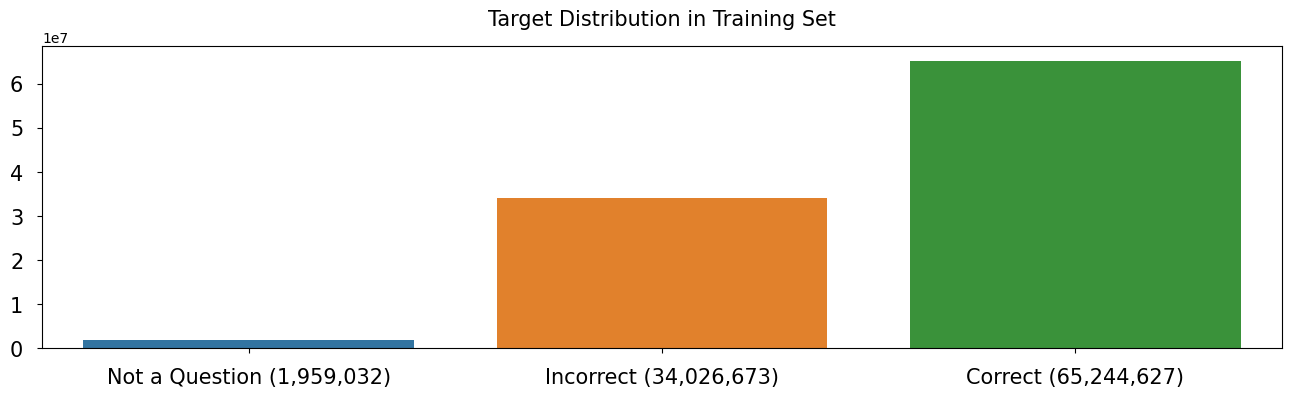

In [12]:
fig = plt.figure(figsize=(16, 4), dpi=100)
    
ax = sns.barplot(x=df_train['answered_correctly'].value_counts().index, y=df_train['answered_correctly'].value_counts().values)

ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels([f'{target} ({value_count:,})' for value_count, target in zip(sorted(df_train['answered_correctly'].value_counts().values), ['Not a Question', 'Incorrect', 'Correct'])])
ax.tick_params(axis='x', labelsize=15, pad=10)
ax.tick_params(axis='y', labelsize=15, pad=10)
ax.set_title(f'Target Distribution in Training Set', size=15, pad=15)

plt.show()

## 4. Questions

### 4.1. Questions, Bundles, and Correct Answers

There are **13523** unique questions and **9765** unique bundles. Number of unique questions in a bundle changes from 1 to 5, but the most common number is 1 (8151 out of 9765 bundles).

Correct answers of the questions are also given in `questions.csv`. Multiple choice question correct answers are usually located in the center (1 or 2) in most of the tests, but it is the opposite in this one. Majority of the correct answers are either 0 or 3, but bias isn't large enough for users to have psychological effects.

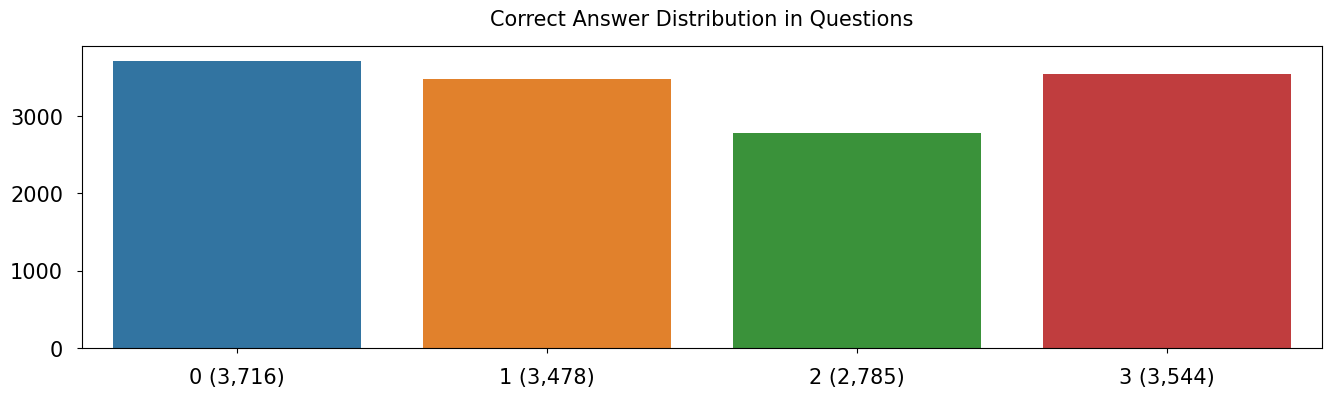

In [13]:
fig = plt.figure(figsize=(16, 4), dpi=100)
    
ax = sns.countplot(df_questions['correct_answer'])

ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels([f'{value} ({count:,})' for value, count in df_questions['correct_answer'].value_counts().sort_index().to_dict().items()])
ax.tick_params(axis='x', labelsize=15, pad=10)
ax.tick_params(axis='y', labelsize=15, pad=10)
ax.set_title(f'Correct Answer Distribution in Questions', size=15, pad=15)

plt.show()

### 4.2. Parts and Sections

There is a feature named `part` in `questions.csv`. It has values from 1 to 7 which corresponds to 7 parts in TOEIC test. Those parts can be seen from [here](https://www.iibc-global.org/english/toeic/test/lr/about/format.html). Parts from 1 to 4 are the listening section and parts from 5 to 7 are the reading section. Those sections are not given in the dataset so they have to be created manually. Label 1 is assigned to listening section and label 2 is assigned to reading section, and `section` feature is downcasted because it will be joined to training set.

It can be seen that 41.7% (5640) of the questions are from the listening section and 58.3% (7883) of the questions are from the reading section. Part distribution is somewhat balanced except part 5 which is defined as **"Select the best answer of the four choices to complete the sentence, and mark your answer on the answer sheet."** on the given url above, and it has the most number of unique questions.

In [14]:
df_questions.loc[df_questions['part'] <= 4, 'section'] = 1
df_questions.loc[df_questions['part'] > 4, 'section'] = 2
df_questions['section'] = df_questions['section'].astype(np.uint8)

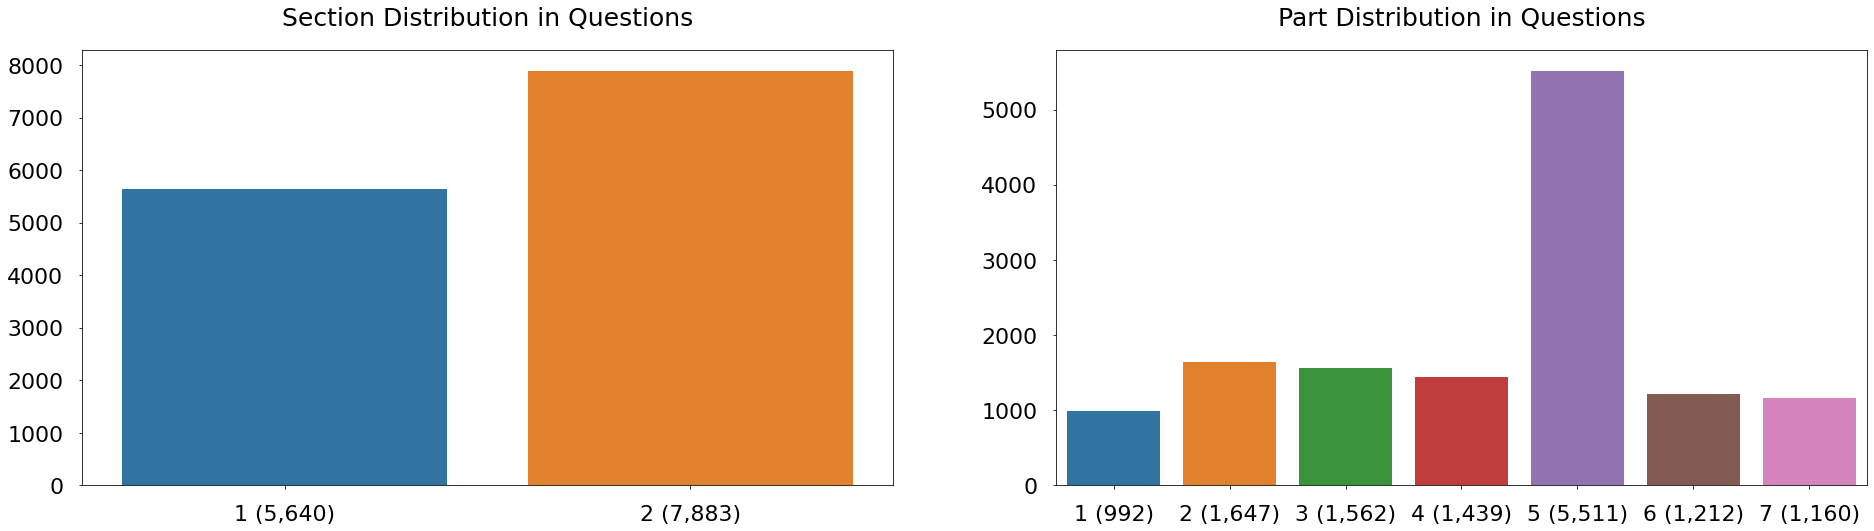

In [15]:
fig, axes = plt.subplots(figsize=(32, 8), ncols=2)
    
sns.countplot(df_questions['section'], ax=axes[0])
sns.countplot(df_questions['part'], ax=axes[1])

for i in range(2):
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=22, pad=15)
    axes[i].tick_params(axis='y', labelsize=22, pad=15)
    
axes[0].set_xticklabels([f'{value} ({count:,})' for value, count in df_questions['section'].value_counts().sort_index().to_dict().items()])
axes[1].set_xticklabels([f'{value} ({count:,})' for value, count in df_questions['part'].value_counts().sort_index().to_dict().items()])
axes[0].set_title(f'Section Distribution in Questions', size=25, pad=25)
axes[1].set_title(f'Part Distribution in Questions', size=25, pad=25)

plt.show()

When correct answer counts in part groups are visualized, it can be seen that there is no single 3rd option correct answer in part 2. Part 2 and 5 are causing the correct answer imbalance. Correct answers are balanced in other parts except part 2 and 5. This suggests some questions in part 5 may have 3 multiple choices like questions in entire part 2. 

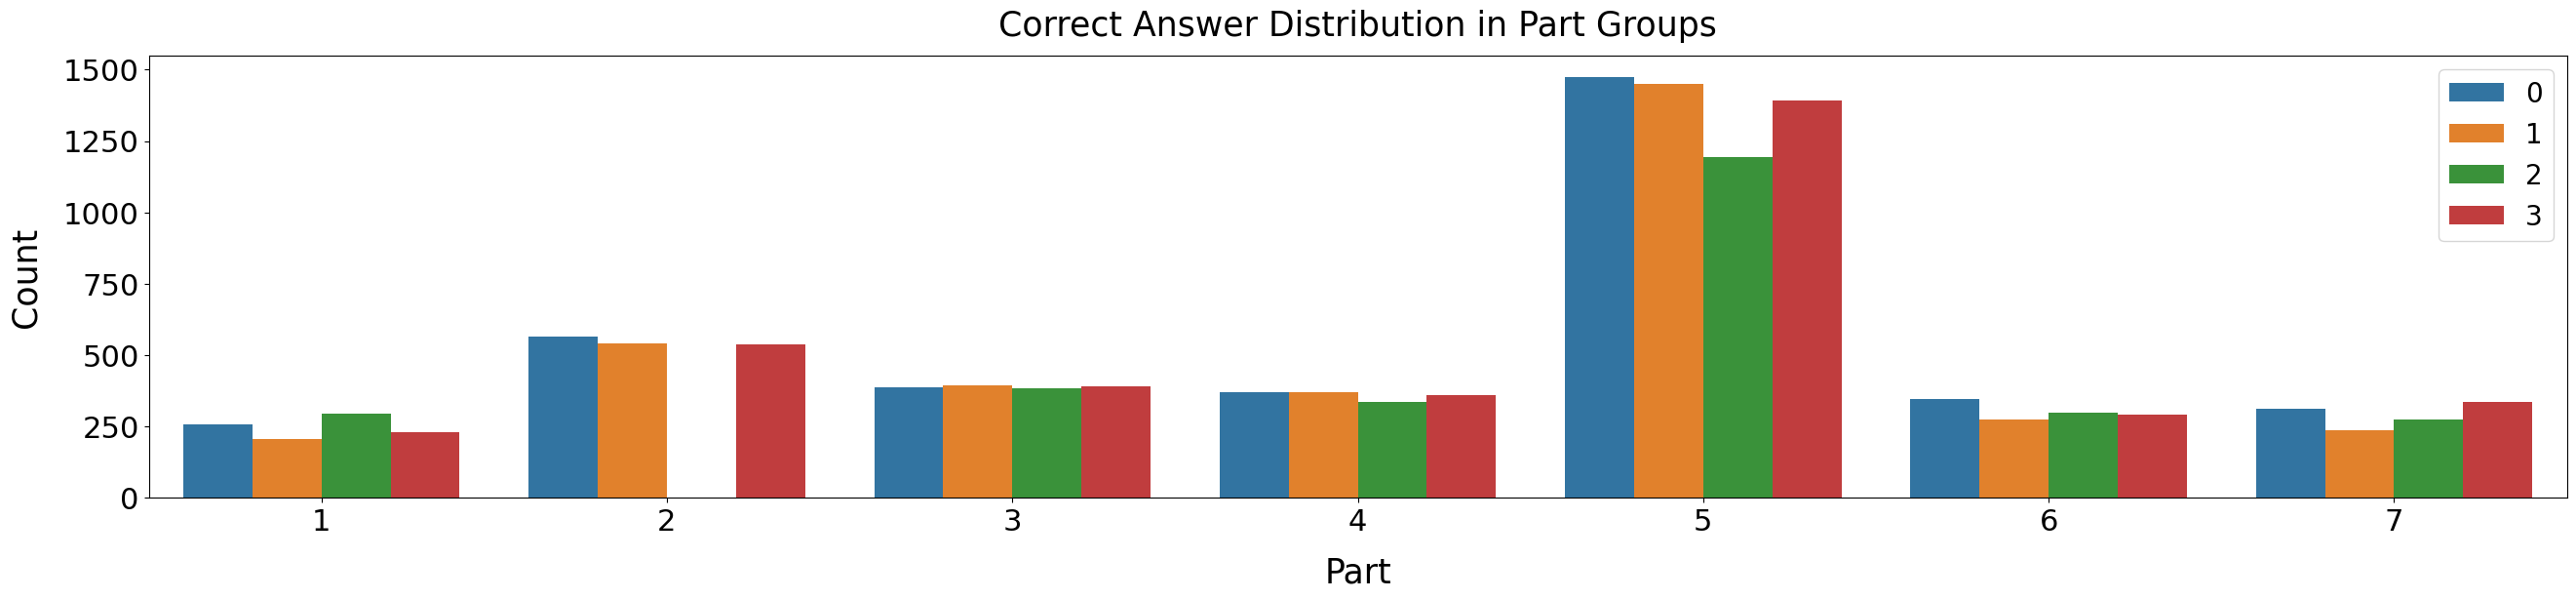

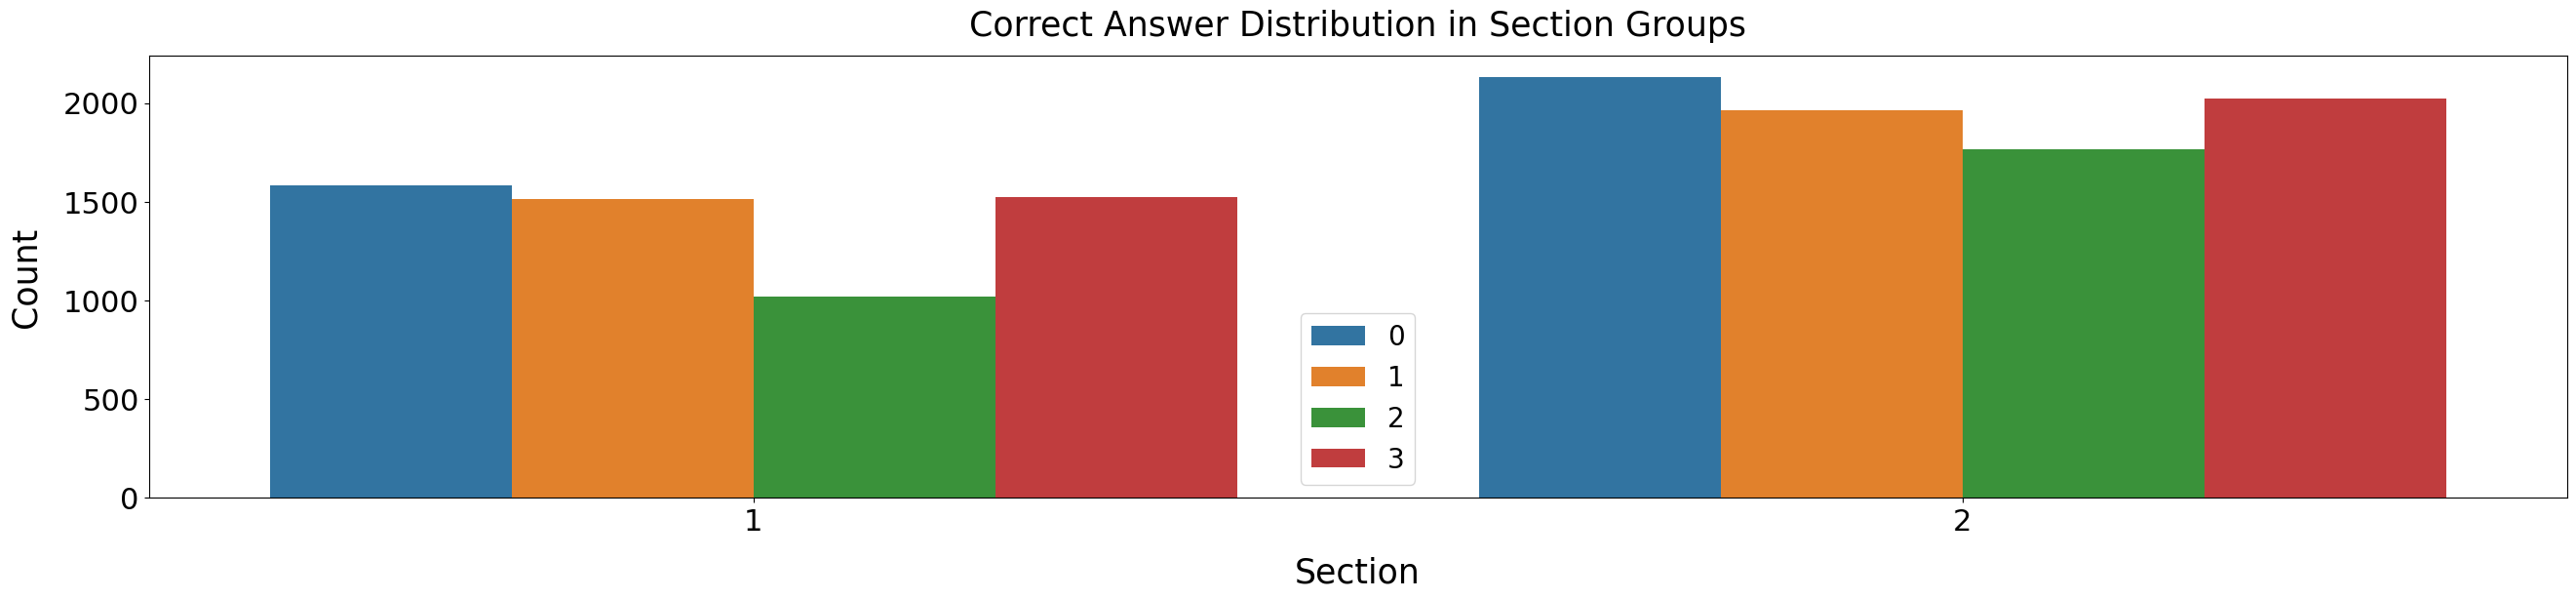

In [16]:
correct_answers_by_parts = df_questions.groupby(['part', 'correct_answer'])['correct_answer'].count().rename('count').reset_index()

fig = plt.figure(figsize=(32, 6), dpi=100)

sns.barplot(x='part',
            y='count',
            hue='correct_answer',
            data=correct_answers_by_parts)

plt.xlabel('Part', size=25, labelpad=15)
plt.ylabel('Count', size=25, labelpad=15)
plt.tick_params(axis='x', labelsize=22)
plt.tick_params(axis='y', labelsize=22)
plt.legend(prop={'size': 20})
plt.title('Correct Answer Distribution in Part Groups', size=25, pad=15)

plt.show()

del correct_answers_by_parts

correct_answers_by_sections = df_questions.groupby(['section', 'correct_answer'])['correct_answer'].count().rename('count').reset_index()

fig = plt.figure(figsize=(32, 6), dpi=100)

sns.barplot(x='section',
            y='count',
            hue='correct_answer',
            data=correct_answers_by_sections)

plt.xlabel('Section', size=25, labelpad=15)
plt.ylabel('Count', size=25, labelpad=15)
plt.tick_params(axis='x', labelsize=22)
plt.tick_params(axis='y', labelsize=22)
plt.legend(prop={'size': 20})
plt.title('Correct Answer Distribution in Section Groups', size=25, pad=15)

plt.show()

del correct_answers_by_sections

### 4.3. Tags

One last feature is left in `questions.csv` and that is `tags`. It is the tag codes of the questions delimited by spaces. This feature should not be joined to training set because data type of the column is object since there are spaces between integers. An object column of 101 million rows would consume too much memory. According to organizers, these codes are sufficient for clustering the questions together. Instead of the tag codes, clusters should be joined to training set.

In [17]:
df_questions[['question_id', 'tags']]

,question_id,tags
0,0,51 131 162 38
1,1,131 36 81
2,2,131 101 162 92
3,3,131 149 162 29
4,4,131 5 162 38
...,...,...
13518,13518,14
13519,13519,8
13520,13520,73
13521,13521,125


## 5. Lectures

### 5.1. Lectures and Tag

There are **418** unique lectures users were watching before answering the questions. Unlike `questions.csv`, `tag` column is not an object type and it's not delimited by spaces in `lectures.csv`. Every lecture has only one tag which corresponds to same tags of the questions, so a lecture can have only one tag while a question can have multiple tags. There are 151 unique tags in both questions and lectures.

In [18]:
df_lectures[['lecture_id', 'tag']].head(10)

,lecture_id,tag
0,89,159
1,100,70
2,185,45
3,192,79
4,317,156
5,335,114
6,484,179
7,641,134
8,761,93
9,814,80


### 5.2. Types, Parts, and Sections

There is a feature named `type_of` in `lectures.csv` which is self-explanatory. 97% of the lectures are either 0 (concept) or 1 (solving question), and 3% of the lectures are either 2 (intention) or 3 (starter). Based on their labels, concept lectures are probably explaining the concepts behind the subject and question solving lectures are about solving sample questions. On the other hand, intention and starter lectures are introduction courses coming before concept and question solving lectures. Users should be able to answer questions correctly after watching concept and question solving lectures for an unseen subject.

Part distribution is unbalanced compared to part distribution in questions. High number of part 5 lectures is the only thing matching between two distributions. Finally, since this file will be joined to training set, it should have `section` feature as well, just like questions.

In [19]:
df_lectures.loc[df_lectures['part'] <= 4, 'section'] = 1
df_lectures.loc[df_lectures['part'] > 4, 'section'] = 2
df_lectures['section'] = df_lectures['section'].astype(np.uint8)

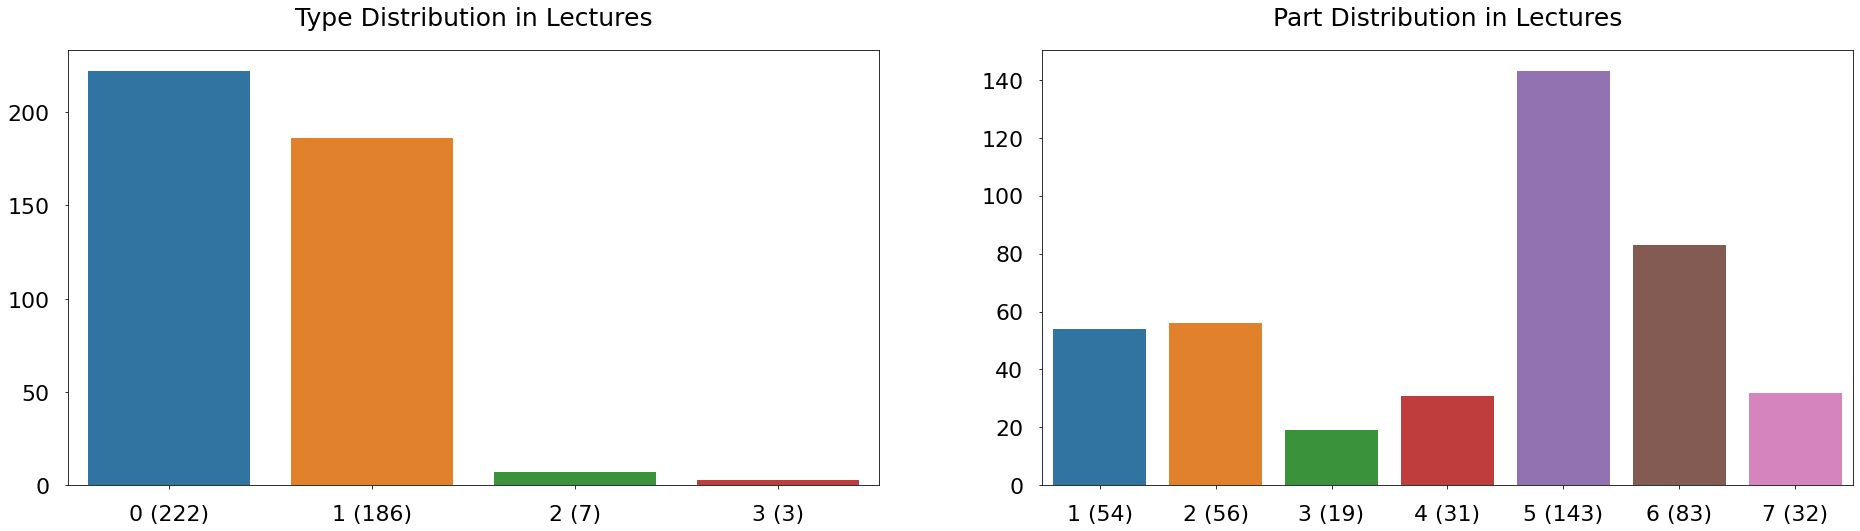

In [20]:
fig, axes = plt.subplots(figsize=(32, 8), ncols=2)
    
sns.countplot(df_lectures['type_of'], ax=axes[0])
sns.countplot(df_lectures['part'], ax=axes[1])

for i in range(2):
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=22, pad=15)
    axes[i].tick_params(axis='y', labelsize=22, pad=15)
    
axes[0].set_xticklabels([f'{value} ({count:,})' for value, count in df_lectures['type_of'].value_counts().sort_index().to_dict().items()])
axes[1].set_xticklabels([f'{value} ({count:,})' for value, count in df_lectures['part'].value_counts().sort_index().to_dict().items()])
axes[0].set_title(f'Type Distribution in Lectures', size=25, pad=25)
axes[1].set_title(f'Part Distribution in Lectures', size=25, pad=25)

plt.show()

## 6. Time Features

There are two time features, and their names are `timestamp` and `prior_question_elapsed_time`. Both of them are in milliseconds (0.001 seconds equals to 1 milliseconds). There is another feature named `task_container_id` and it monotonically increases for each user, so it should be analyzed together with previously mentioned time features. Those features can be confusing at first glance, but they are detailedly explained in this section.

### 6.1. Timestamp

`timestamp` is the total milliseconds between user's current activity and first activity completed by that user. This value is entered when the current activity is **completed** by the user, so this feature is on user level. Every user have their own `timestamp` starting from 0 to their completed last activity. This means even if the users have spent any time on another activity after their last completed activity, that activity won't be entered if it is not completed.

For every user, `timestamp` starts from 0 and ends at their last completed activity. That's why 0 is the most common value in `timestamp` histogram. However, number of 0 values doesn't match the number of unique users, because some of the questions are given to users in a batch. In those cases, all questions in the same batch will share the same `timestamp` of the last completed activity. For instance, user 368624 had recieved 4 question batch in each activity, and `timestamp` value is shared on those activities. `task_container_id` column is there for distinguishing whether the consecutive questions are in a batch, or not. Questions that are given in a batch have the same `task_container_id`, and it can be seen from the sample below.

In [21]:
first_timestamps = df_train.groupby('user_id')['timestamp'].first()
last_timestamps = df_train.groupby('user_id')['timestamp'].nth(-1)

print(f'There are {df_train["user_id"].nunique():,} users in training set')
print(f'There are {df_train[df_train["timestamp"] == 0].shape[0]:,} 0 timestamps in training set')
print(f'{first_timestamps[first_timestamps == 0].shape[0]:,} users first timestamp is 0')
print(f'{last_timestamps[last_timestamps == 0].shape[0]:,} users last timestamp is 0')

del first_timestamps, last_timestamps

df_train[df_train['user_id'] == 368624].head(12).style.background_gradient(subset=['task_container_id', 'timestamp'], cmap='viridis')

There are 393,656 users in training set
There are 396,417 0 timestamps in training set
393,656 users first timestamp is 0
89 users last timestamp is 0


,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
22522,22522,0,368624,6820,0,0,2,0,47250.000000,0
22523,22523,0,368624,6818,0,0,3,0,47250.000000,0
22524,22524,0,368624,6817,0,0,1,1,47250.000000,0
22525,22525,0,368624,6819,0,0,2,1,47250.000000,0
22526,22526,191445,368624,6611,0,1,2,0,47250.000000,0
22527,22527,191445,368624,6612,0,1,0,1,47250.000000,0
22528,22528,191445,368624,6609,0,1,2,1,47250.000000,0
22529,22529,191445,368624,6610,0,1,1,1,47250.000000,0
22530,22530,439194,368624,6597,0,2,1,0,46250.000000,0
22531,22531,439194,368624,6600,0,2,2,1,46250.000000,0


`timestamp` follows a skewed right distribution with lots of zeros because it is the only value that every user have in their first activities. Other nth activities of users can be any number because `timestamp` is in milliseconds, thus, cardinality is very high.

Statistical measures of this variable are on a very large scale that they should be analyzed as days. Mean of `timestamp` is 89.2 days and median is 30.95 days. Difference between those two measures shows how big extreme values are. Some users waited very long time between their activities. The max value in `timestamp` is 7,703,643,654.326523 milliseconds which is equal to 1011.87 days and 2.77 years.

timestamp
---------
Train Mean: 7,703,643,654.326523 - Median: 2,674,233,764.5 - Std: 11,592,655,308.525589 - Var 1.3438965577472339e+20
Train Min: 0 - Max: 87,425,772,049 - Skew 2.388 - Kurt 6.436 


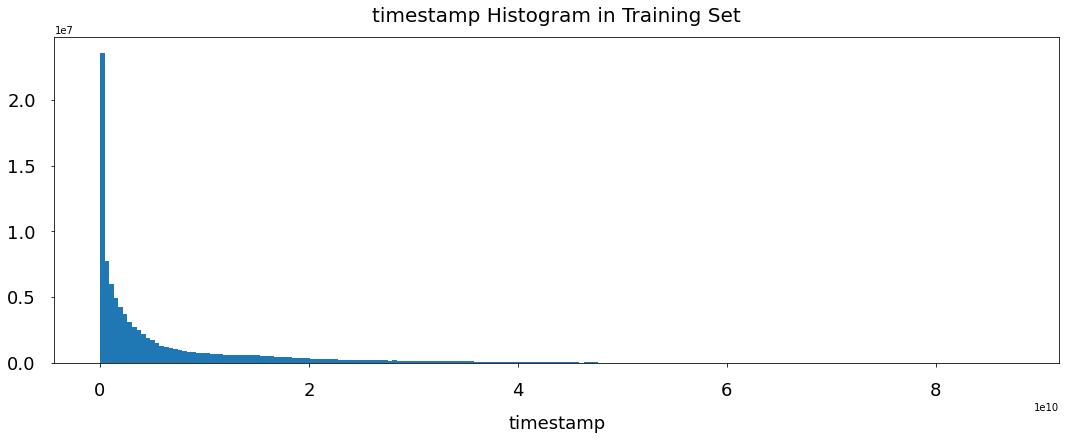

In [22]:
train_mean = df_train['timestamp'].mean()
train_median = df_train['timestamp'].median()
train_std = df_train['timestamp'].std()
train_min = df_train['timestamp'].min()
train_max = df_train['timestamp'].max()
train_skew = skew(df_train['timestamp'])
train_kurt = kurtosis(df_train['timestamp'])
train_var = np.var(df_train['timestamp'])

print(f'timestamp\n{"-" * 9}')
print(f'Train Mean: {train_mean:,} - Median: {train_median:,} - Std: {train_std:,} - Var {train_var:,}')
print(f'Train Min: {train_min:,} - Max: {train_max:,} - Skew {train_skew:.4} - Kurt {train_kurt:.4} ')

figure = plt.figure(figsize=(18, 6))

plt.hist(df_train['timestamp'], bins=200)
plt.xlabel('timestamp', size=18, labelpad=15)
plt.ylabel('')
plt.tick_params(axis='x', labelsize=18, pad=15)
plt.tick_params(axis='y', labelsize=18, pad=15)
plt.title('timestamp Histogram in Training Set', size=20, pad=15)

plt.show()

del train_mean, train_median, train_std, train_min, train_max, train_skew, train_kurt, train_var

### 6.2. Prior Question Elapsed Time

`prior_question_elapsed_time` is the average time in milliseconds a user spent to answer each question on the previous batch. Unlike `timestamp`, this value is the **average** time, so it doesn't monotonically increase and it has low cardinality compared to `timestamp` It is also entered when the current activity is completed by the user **if the completed activity is a question**. Lectures between questions are ignored. This feature is on user level as well, but there is one more important thing to consider.

In order to find the total amount of time spent on a batch, `prior_question_elapsed_time` values should be summed in `[user_id, task_container_id]` groups because it is the average time spent on **each** question from the previous batch. Based on the sample below, user 368624 spent 47250 milliseconds on each question in task container 0 and task container 1. Those batches have 4 questions in them so total amount of time spent on those batches are 189000 milliseconds.

In [23]:
df_train[df_train['user_id'] == 368624].head(12).style.background_gradient(subset=['task_container_id', 'prior_question_elapsed_time'], cmap='viridis')

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
22522,22522,0,368624,6820,0,0,2,0,47250.000000,0
22523,22523,0,368624,6818,0,0,3,0,47250.000000,0
22524,22524,0,368624,6817,0,0,1,1,47250.000000,0
22525,22525,0,368624,6819,0,0,2,1,47250.000000,0
22526,22526,191445,368624,6611,0,1,2,0,47250.000000,0
22527,22527,191445,368624,6612,0,1,0,1,47250.000000,0
22528,22528,191445,368624,6609,0,1,2,1,47250.000000,0
22529,22529,191445,368624,6610,0,1,1,1,47250.000000,0
22530,22530,439194,368624,6597,0,2,1,0,46250.000000,0
22531,22531,439194,368624,6600,0,2,2,1,46250.000000,0


`prior_question_elapsed_time` follows a skewed right distribution just like `timestamp`, but without lots of zeros. Top 5 most common values in `prior_question_elapsed_time` are 15000, 16000, 17000, 18000, and 19000 with total 22234917 occurences. All of the values are multipliers of 10, which suggests, data is stored as seconds and converted to milliseconds afterwards. Cardinality is low because of this reason.

Statistical measures of this variable are not on a very large scale thus they can be analyzed as seconds. Mean of `prior_question_elapsed_time` is 13 seconds and median is 21.2 seconds. Difference between those two measures can be explained with the long right tail. The max value in `prior_question_elapsed_time` is exactly 5 minutes which is probably the total amount of time given to users for a single question. The min value in `prior_question_elapsed_time` is 0.0 and that is probably users randomly selecting answers. 

prior_question_elapsed_time
---------------------------
Train Mean: 13,005.0810546875 - Median: 21,000.0 - Std: 2.123e+04 - Var 4.506e+08
Train Min: 0.0 - Max: 300,000.0 - Skew 4.823 - Kurt 45.15 


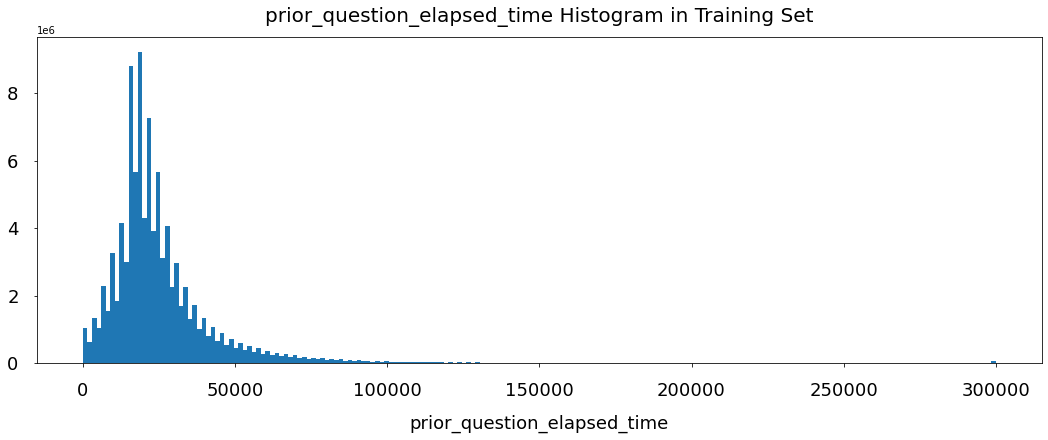

In [24]:
train_mean = df_train['prior_question_elapsed_time'].mean()
train_median = df_train['prior_question_elapsed_time'].median()
train_std = df_train['prior_question_elapsed_time'].std()
train_min = df_train['prior_question_elapsed_time'].min()
train_max = df_train['prior_question_elapsed_time'].max()
train_skew = skew(df_train['prior_question_elapsed_time'].dropna())
train_kurt = kurtosis(df_train['prior_question_elapsed_time'].dropna())
train_var = np.var(df_train['prior_question_elapsed_time'])

print(f'prior_question_elapsed_time\n{"-" * 27}')
print(f'Train Mean: {train_mean:,} - Median: {train_median:,} - Std: {train_std:.4} - Var {train_var:.4}')
print(f'Train Min: {train_min:,} - Max: {train_max:,} - Skew {train_skew:.4} - Kurt {train_kurt:.4} ')

figure = plt.figure(figsize=(18, 6))

plt.hist(df_train['prior_question_elapsed_time'], bins=200)
plt.xlabel('prior_question_elapsed_time', size=18, labelpad=15)
plt.ylabel('')
plt.tick_params(axis='x', labelsize=18, pad=15)
plt.tick_params(axis='y', labelsize=18, pad=15)
plt.title('prior_question_elapsed_time Histogram in Training Set', size=20, pad=15)

plt.show()

del train_mean, train_median, train_std, train_min, train_max, train_skew, train_kurt, train_var

### 6.3. Task Container ID

`task_container_id` is the unique identifier of the batch of questions or lectures. It starts from 0 and it monotonically increases for every user exactly like `timestamp`. It is added for identifying multiple questions or lectures in different batches. `content_id` of questions in a batch can change but they have same `task_container_id`. This can be seen from the sample below.

In [25]:
first_task_container_ids = df_train.groupby('user_id')['task_container_id'].first()
last_task_container_ids = df_train.groupby('user_id')['task_container_id'].nth(-1)

print(f'There are {df_train["user_id"].nunique():,} users in training set')
print(f'There are {df_train[df_train["timestamp"] == 0].shape[0]:,} 0 task_container_id in training set')
print(f'{first_task_container_ids[first_task_container_ids == 0].shape[0]:,} users first task_container_id is 0')
print(f'{last_task_container_ids[last_task_container_ids == 0].shape[0]:,} users last task_container_id is 0')

del first_task_container_ids, last_task_container_ids

df_train[df_train['user_id'] == 368624].head(12).style.background_gradient(subset=['task_container_id', 'content_id'], cmap='viridis')

There are 393,656 users in training set
There are 396,417 0 task_container_id in training set
390,829 users first task_container_id is 0
111 users last task_container_id is 0


,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
22522,22522,0,368624,6820,0,0,2,0,47250.000000,0
22523,22523,0,368624,6818,0,0,3,0,47250.000000,0
22524,22524,0,368624,6817,0,0,1,1,47250.000000,0
22525,22525,0,368624,6819,0,0,2,1,47250.000000,0
22526,22526,191445,368624,6611,0,1,2,0,47250.000000,0
22527,22527,191445,368624,6612,0,1,0,1,47250.000000,0
22528,22528,191445,368624,6609,0,1,2,1,47250.000000,0
22529,22529,191445,368624,6610,0,1,1,1,47250.000000,0
22530,22530,439194,368624,6597,0,2,1,0,46250.000000,0
22531,22531,439194,368624,6600,0,2,2,1,46250.000000,0


`task_container_id` has a skewed right distribution which is very similar to `timestamp` because both of those features start from 0 and monotonically increase for every user. Histograms of those two features are almost identical since both of them increase at the same timesteps.

The max value in `task_container_id` is 9999 and the min value in `task_container_id` is 0. Those 10,000 task containers could be size of the entire program in chronological order or they could be arbitrary numbers.

task_container_id
---------------------------
Train Mean: 904.062365596114 - Median: 382.0 - Std: 1.358e+03 - Var 1.845e+06
Train Min: 0 - Max: 9,999 - Skew 2.878 - Kurt 10.15 


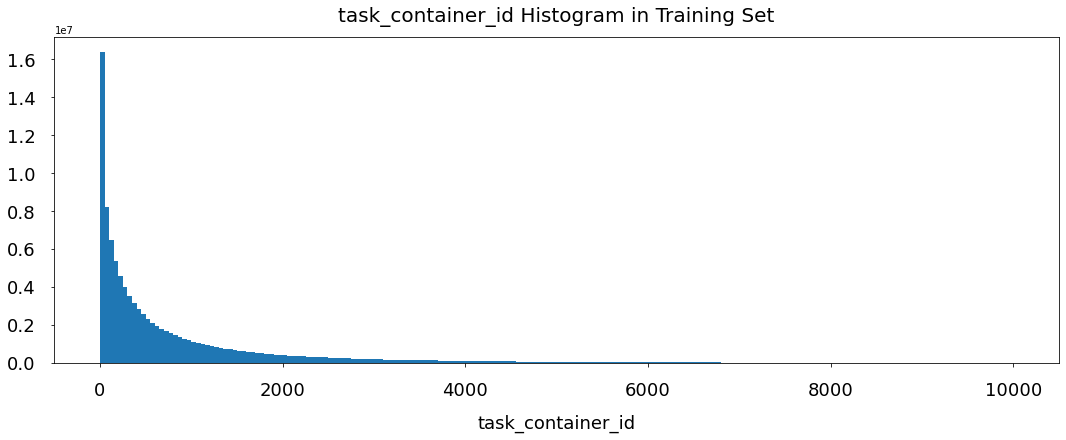

In [26]:
train_mean = df_train['task_container_id'].mean()
train_median = df_train['task_container_id'].median()
train_std = df_train['task_container_id'].std()
train_min = df_train['task_container_id'].min()
train_max = df_train['task_container_id'].max()
train_skew = skew(df_train['task_container_id'].dropna())
train_kurt = kurtosis(df_train['task_container_id'].dropna())
train_var = np.var(df_train['task_container_id'])

print(f'task_container_id\n{"-" * 27}')
print(f'Train Mean: {train_mean:,} - Median: {train_median:,} - Std: {train_std:.4} - Var {train_var:.4}')
print(f'Train Min: {train_min:,} - Max: {train_max:,} - Skew {train_skew:.4} - Kurt {train_kurt:.4} ')

figure = plt.figure(figsize=(18, 6))

plt.hist(df_train['task_container_id'], bins=200)
plt.xlabel('task_container_id', size=18, labelpad=15)
plt.ylabel('')
plt.tick_params(axis='x', labelsize=18, pad=15)
plt.tick_params(axis='y', labelsize=18, pad=15)
plt.title('task_container_id Histogram in Training Set', size=20, pad=15)

plt.show()

del train_mean, train_median, train_std, train_min, train_max, train_skew, train_kurt, train_var